In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.drive_and_act_keypoint_dataset import DriveAndActKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path


pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/drive_and_act/')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
# ------------
# saved model path
# ------------
model_suffix = 'all_actor'
# pretrained_model_path = f'saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model_{model_suffix}'
pretrained_model_path = './saved_lifter_2d_3d_model/drive_and_act/prediction/linear_model_all_actors'
with open(f'{pretrained_model_path}/best_model_path.txt', 'r') as f:
    checkpoint_path = f.readline()

# saved_model_path = f'./saved_lifter_2d_3d_model/visualization'

Global seed set to 1234


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at saved_lifter_2d_3d_model/drive_and_act/prediction/linear_model_all_actors/lightning_logs/version_1/checkpoints/epoch=49-step=17850.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/drive_and_act/prediction/linear_model_all_actors/lightning_logs/version_1/checkpoints/epoch=49-step=17850.ckpt


test_dataset 8414


Testing: 0it [00:00, ?it/s]

MPJPE: 64.13793770846667
PJPE
                      PJPE
nose             54.771415
left_eye         45.856081
right_eye        48.827342
left_ear         11.191579
right_ear        44.655020
left_shoulder    49.244591
right_shoulder   44.457220
left_elbow       68.437874
right_elbow      70.014827
left_wrist       80.291338
right_wrist     109.324527
left_hip         41.269602
right_hip        37.365527
activities_mpjpe:
{}
test mpjpe: 64.13793770846667


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │     64.13793770846667     │
└───────────────────────────┴───────────────────────────┘

torch.Size([13, 2])
torch.Size([13, 2])
torch.Size([13, 2])


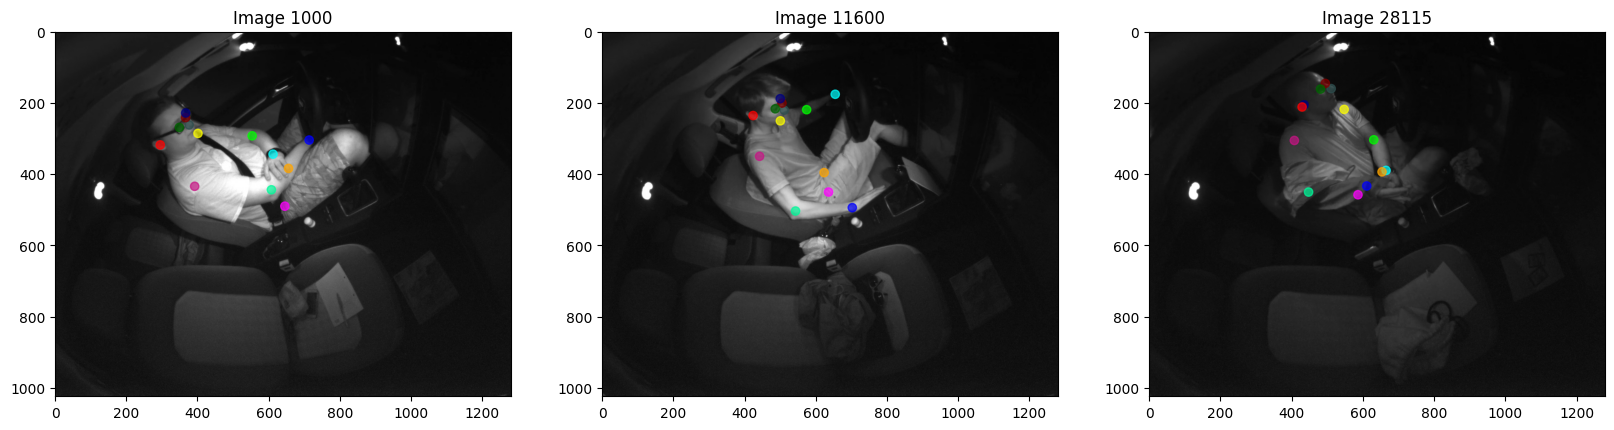

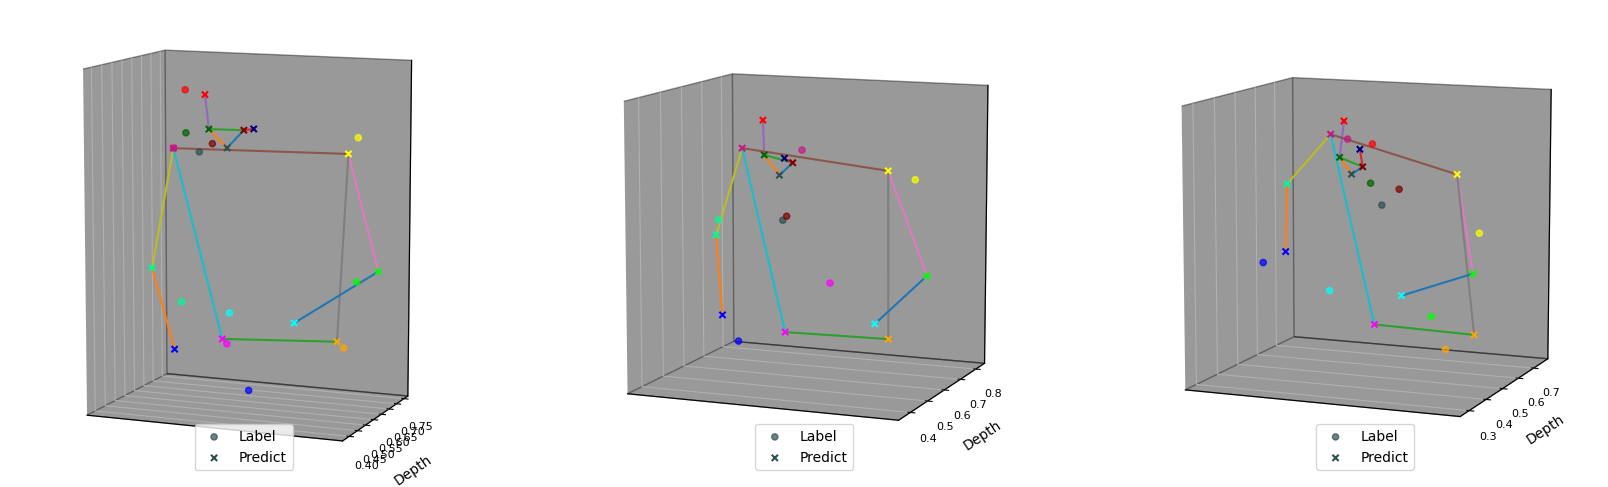

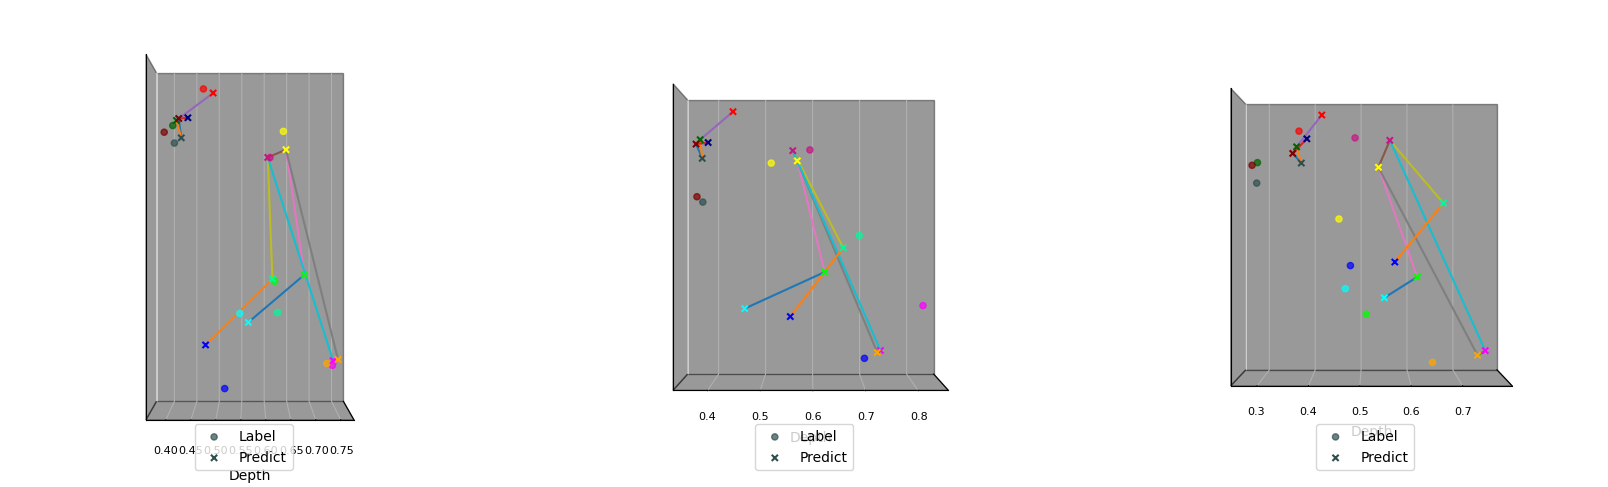

In [2]:
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_knee=True)
lit_model.load_from_checkpoint(checkpoint_path)
test_actors = ['vp13', 'vp14', 'vp15']
test_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    actors=test_actors,
    exclude_ankle=True,
    exclude_knee=True
)

print(
    'test_dataset', len(test_dataset)
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)
model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=early_stopping_patience)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

saved_model_path = f'./saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model_{model_suffix}'
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.test(model=lit_model, ckpt_path=checkpoint_path, dataloaders=test_loader)
plot_samples(
    dataset_root_path,
    lit_model,
    test_loader,
    'train',
    img_figsize=(20, 10),
    img_width=image_width,
    img_height=image_height,
    plot_figsize=(20.5, 10),
    sample_idices=[1000, 2500, 6000],
    is_plot_gt_skeleton=False
)